In [22]:
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# import tensorflow as tf
# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [23]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from matplotlib.patches import Rectangle
from matplotlib import cm
import math
import os
import pandas as pd
from IPython.display import display, Latex
import ast

In [24]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [25]:
# tf.random.set_seed(42)
# np.random.seed(42)

In [26]:
tf.keras.backend.set_floatx("float64")

In [27]:
def record_and_update_performance(value, filename):
    existing_times = []
    try:
        with open(filename, 'r') as file:
            for line in file:
                line = line.strip()
                if line.startswith('[') and line.endswith(']'):
                    try:
                        numbers = ast.literal_eval(line)
                        if isinstance(numbers, list):
                            existing_times.extend(numbers)
                    except (SyntaxError, ValueError):
                        print(f"Skipping invalid list format: {line}")
                elif line.replace('.', '', 1).isdigit():
                    try:
                        existing_times.append(float(line))
                    except ValueError:
                        print(f"Skipping invalid float format: {line}")
                else:
                    print(f"Skipping non-numeric line: {line}")
    except FileNotFoundError:
        print("No existing file found. A new file will be created.")

    existing_times.append(value)
    
    avg = np.mean(existing_times)
    min_val = np.min(existing_times)
    max_val = np.max(existing_times)
    
    deviation_min = avg - min_val
    deviation_max = max_val - avg
    
    with open(filename, 'w') as file:
        for time_record in existing_times:
            file.write(f"{time_record}\n")
        minutes_avg = int(avg // 60)
        seconds_avg = int(avg % 60)
        text = f"Average among {len(existing_times)} trainings: {minutes_avg:.2f}min {seconds_avg}s, (Deviation from Min: {deviation_min:.2f}s, Deviation from Max: {deviation_max:.2f}s), STD: {np.std(existing_times)}\n"
        file.write(text)
        print(text)
    
    print("Updated data recorded successfully.")


In [28]:
class Heat1DPINN():
    def __init__(self, input_shape=1, out_shape=1, layers=[10, 10, 10], activation='tanh', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-04)):
        super(Heat1DPINN, self).__init__()
        self.optimizer = optimizer
        self.model = self.build(input_shape, out_shape, layers, activation)

    def build(self, input_shape, output_shape, layers, activation):
        input_layer = tf.keras.layers.Input(shape=(input_shape,))
        kernel_initializer=tf.keras.initializers.GlorotNormal()

        hidden = [tf.keras.layers.Dense(layers[0], activation=activation)(input_layer)]
        for i in range(1, len(layers)):
            new_layer = tf.keras.layers.Dense(
                    layers[i],
                    activation=activation,
                    activity_regularizer=None,
                    kernel_initializer=kernel_initializer
                )(hidden[-1])
            hidden.append(new_layer)

        output_layer = tf.keras.layers.Dense(output_shape, activation=None)(hidden[-1])

        name = f"DNN-{len(layers)}"
        model = tf.keras.Model(input_layer, output_layer, name=name)
        model.summary()
    
        return model

    @tf.function
    def dirichlet_condition(self, x_bc_time, t_bc_time, u_bc_time, x_bc_space, t_bc_space, u_bc_space):
        x_t_time = tf.concat([x_bc_time, t_bc_time], axis=1)
        x_t_space = tf.concat([x_bc_space, t_bc_space], axis=1)
        u_time = self.model(x_t_time)
        u_space = self.model(x_t_space)
        return 10 * tf.reduce_mean(tf.square(u_time - u_bc_time)) + tf.reduce_mean(tf.square(u_space - u_bc_space))

    @tf.function
    def loss_fn(self, x_in, t_in, x_bc_time, t_bc_time, u_bc_time, x_bc_space, t_bc_space, u_bc_space):
        x_t = tf.concat([x_in, t_in], axis=1)
        u0 = self.model(x_t)
        u_x = tf.gradients(u0, x_in)[0]
        u_t = tf.gradients(u0, t_in)[0]
        u_xx = tf.gradients(u_x, x_in)[0]
        heat_eq = u_t - u_xx
        bc_dirichlet = self.dirichlet_condition(x_bc_time, t_bc_time, u_bc_time, x_bc_space, t_bc_space, u_bc_space)

        return 0.7 * tf.reduce_mean(tf.square(heat_eq)) + 5 * bc_dirichlet
    
    def save_model(self, epoch, base_path='model_1d_heat_checkpoints'):
        if not os.path.exists(base_path):
            os.makedirs(base_path)
        model_path = os.path.join(base_path, f'model_1d_heat_at_epoch_{epoch}.h5')
        self.model.save(model_path)
        print(f"Model saved at {model_path}")

    def train(self, loss_threshold, x_in, t_in, x_bc_time, t_bc_time, u_bc_time, x_bc_space, t_bc_space, u_bc_space):
        loss_array = []
        start_time = time.time()
        best_epoch_times = math.inf
        loss = tf.constant(float('inf'))
        epoch = 0
        try:
            while loss.numpy() > loss_threshold:
                with tf.GradientTape() as tape:
                    loss = self.loss_fn(x_in, t_in, x_bc_time, t_bc_time, u_bc_time, x_bc_space, t_bc_space, u_bc_space)
                grads = tape.gradient(loss, self.model.trainable_variables)
                self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

                elapsed_time = time.time() - start_time
                if (best_epoch_times > elapsed_time):
                    best_epoch_times = elapsed_time
                minutes = int(elapsed_time // 60)
                seconds = int(elapsed_time % 60)
                loss_array.append(loss)
                if epoch % 100 == 0:
                    print(f'Epoch {epoch}, Loss: {loss.numpy()}, Min loss: {min(loss_array)}, time: {"%d minutes and %d seconds" % (minutes, seconds)}')
                if epoch % 1000 == 0 and epoch != 0:
                    self.save_model(epoch)
                epoch += 1
        except KeyboardInterrupt:
            print("Training stopped manually")

        elapsed_time = time.time() - start_time
        minutes = int(elapsed_time // 60)
        seconds = int(elapsed_time % 60)
        print("Training took %d minutes and %d seconds" % (minutes, seconds))
        print(f"Last epoch: {epoch}, loss: {loss.numpy()}")
        print(f"Best epoch: {np.argmin(loss_array)}, loss: {min(loss_array)}, time: {best_epoch_times}")
        record_and_update_performance(elapsed_time, 'performance_data_1d_heat.txt')

        plt.figure()
        plt.plot(loss_array)
        plt.xlabel('Епоха')
        plt.ylabel('Втрати')
        plt.grid()
        plt.title('Значення втрат')
        plt.savefig("1d_nonstationary_heat_equation_training.png")
        plt.show(block=False)

        start_epoch = 1000
        end_epoch = 3000

        end_epoch = min(end_epoch, len(loss_array) - 1)

        plt.plot(range(start_epoch, end_epoch + 1), loss_array[start_epoch:end_epoch + 1])
        plt.xlabel('Епоха')
        plt.ylabel('Втрати')
        plt.grid()
        plt.title('Значення втрат від 1000 до 3000 епохи')
        plt.show(block=False)

In [29]:
N_of_train_points_2D = 25
N_of_test_points_2D = 200
N_of_fem_points_2D = 25
N_of_time_steps = 100
L_x = 0.0
R_x = 1.0
L_t = 0.0
R_t = 0.2
Dirichlet_up_2D = 0.0
Dirichlet_down_2D = 0.0
loss_threshold_2D = 0.025
Layers_2D = [30, 30, 30]
Learning_rate_2D = 5e-4
Optimizer_2D = tf.keras.optimizers.Adam(learning_rate=Learning_rate_2D)

In [30]:
model_2D = Heat1DPINN(2, 1, Layers_2D, 'tanh', Optimizer_2D)
# tf.keras.utils.plot_model(model_2D.model, to_file='model_plot.png', show_shapes=True, 
#                           show_layer_names=True, show_dtype=True, 
#                           show_layer_activations=True)

Model: "DNN-3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_4 (Dense)             (None, 30)                90        
                                                                 
 dense_5 (Dense)             (None, 30)                930       
                                                                 
 dense_6 (Dense)             (None, 30)                930       
                                                                 
 dense_7 (Dense)             (None, 1)                 31        
                                                                 
Total params: 1,981
Trainable params: 1,981
Non-trainable params: 0
_________________________________________________________________


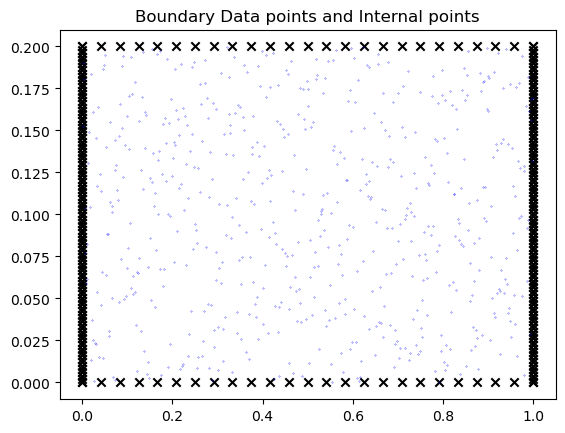

In [31]:
n_bc_space = 2
n_bc_time = 2
n_bc = 4

Nc = N_of_train_points_2D * N_of_train_points_2D

data_space = np.zeros([n_bc_space, N_of_train_points_2D, 3])
data_time = np.zeros([n_bc_time, N_of_time_steps, 3])

for i, j in zip(range(n_bc), [L_x, R_x, L_t, R_t]):
    if i < 2:
        points = np.linspace(L_t, R_t, N_of_time_steps)
        data_time[i, :, 0] = j
        data_time[i, :, 1] = points
    else:
        points = np.linspace(L_x, R_x, N_of_train_points_2D)
        data_space[i-2, :, 0] = points
        data_space[i-2, :, 1] = j

data_time[0, :, 2] = 0.0
data_time[1, :, 2] = 0.0
values = np.sin(math.pi*data_space[0, :, 0]) - np.sin(2*math.pi*data_space[0, :, 0]) + np.sin(3*math.pi*data_space[0, :, 0])
data_space[0, :, 2] = values

data_space = data_space.reshape(N_of_train_points_2D * n_bc_space, 3)
data_time = data_time.reshape(N_of_time_steps * n_bc_time, 3)

x_bc_time, t_bc_time, u_bc_time = map(lambda x: np.expand_dims(x, axis=1), 
                    [data_time[:, 0], data_time[:, 1], data_time[:, 2]])

x_bc_space, t_bc_space, u_bc_space = map(lambda x: np.expand_dims(x, axis=1), 
                    [data_space[:, 0], data_space[:, 1], data_space[:, 2]])

X_1, X_2 = np.meshgrid(np.linspace(L_x, R_x, N_of_train_points_2D), np.linspace(L_t, R_t, N_of_train_points_2D))
colloc = np.vstack([X_1.ravel(), X_2.ravel()]).T

colloc = np.column_stack((L_x + colloc[:,0] * (R_x - L_x), L_t + colloc[:,1] * (R_t - L_t)))

x_in, t_in = map(lambda x: np.expand_dims(x, axis=1), 
               [colloc[:, 0], colloc[:, 1]])

plt.title("Boundary Data points and Internal points")
plt.scatter(data_time[:, 0], data_time[:, 1], marker="x", c="k", label="BDP")
plt.scatter(data_space[:, 0], data_space[:, 1], marker="x", c="k", label="BDP")
plt.scatter(colloc[:, 0], colloc[:, 1], s=.2, marker=".", c="b", label="CP")
plt.show()

x_in, t_in, x_bc_time, t_bc_time, u_bc_time, x_bc_space, t_bc_space, u_bc_space = map(
    lambda x: tf.convert_to_tensor(x,dtype=tf.float64),
    [x_in, t_in, x_bc_time, t_bc_time, u_bc_time, x_bc_space, t_bc_space, u_bc_space]
)

2024-05-16 09:10:32.268214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_20' with dtype int32
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_20}}]]
2024-05-16 09:10:32.268347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_21' with dtype int32
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_21}}]]


Epoch 0, Loss: 6.767975107965011, Min loss: 6.767975107965011, time: 0 minutes and 2 seconds
Epoch 100, Loss: 3.4669552229247005, Min loss: 3.4669552229247005, time: 0 minutes and 3 seconds
Epoch 200, Loss: 3.4166972039544987, Min loss: 3.4166972039544987, time: 0 minutes and 5 seconds
Epoch 300, Loss: 3.3331994662298223, Min loss: 3.3331994662298223, time: 0 minutes and 6 seconds
Epoch 400, Loss: 3.210104565583936, Min loss: 3.210104565583936, time: 0 minutes and 8 seconds
Epoch 500, Loss: 3.1432048770692522, Min loss: 3.1432048770692522, time: 0 minutes and 9 seconds
Epoch 600, Loss: 3.1153419564215286, Min loss: 3.1153419564215286, time: 0 minutes and 11 seconds
Epoch 700, Loss: 3.094579202084725, Min loss: 3.094579202084725, time: 0 minutes and 13 seconds
Epoch 800, Loss: 3.0771640543485854, Min loss: 3.0771640543485854, time: 0 minutes and 14 seconds
Epoch 900, Loss: 3.0612869789606925, Min loss: 3.0612869789606925, time: 0 minutes and 16 seconds
Epoch 1000, Loss: 3.04406180490767

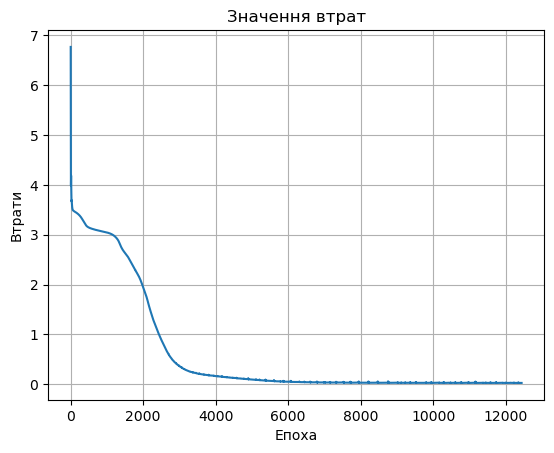

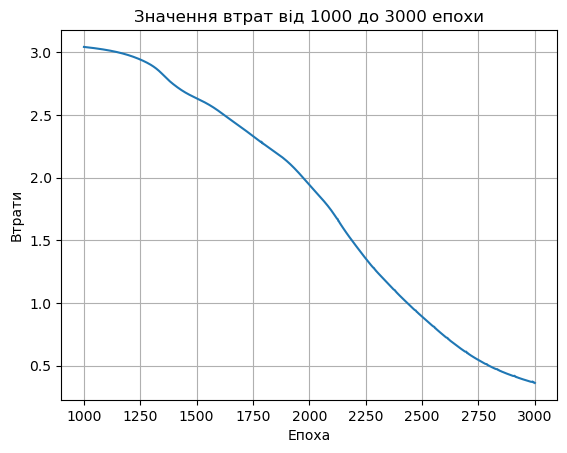

In [32]:
model_2D.train(loss_threshold_2D, x_in, t_in, x_bc_time, t_bc_time, u_bc_time, x_bc_space, t_bc_space, u_bc_space)

In [33]:
x_test = np.linspace(L_x, R_x, N_of_test_points_2D)
t_test = np.linspace(L_t, R_t, N_of_time_steps+1)
x_mesh, t_mesh = np.meshgrid(x_test, t_test)
xt_test = np.column_stack([x_mesh.ravel(), t_mesh.ravel()])

u_pinn = model_2D.model(xt_test).numpy().reshape(t_test.size, x_test.size)

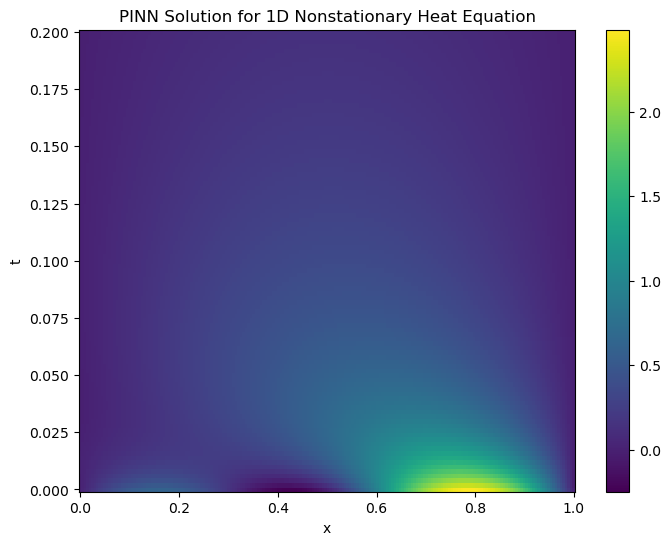

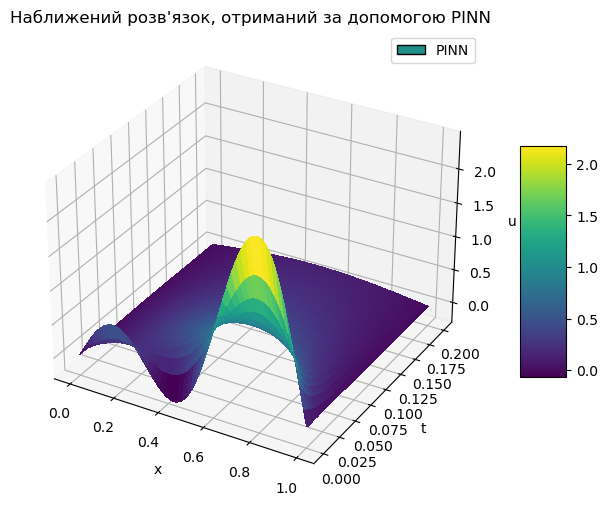

In [34]:
plt.figure(figsize=(8, 6))
plt.pcolor(x_mesh, t_mesh, u_pinn, cmap='viridis')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('PINN Solution for 1D Nonstationary Heat Equation')
plt.savefig("1d_nonstationary_heat_exact_solution_heatmap.png")
plt.show(block=False)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x_mesh, t_mesh, u_pinn, cmap='viridis', linewidth=0, antialiased=False, label='PINN Solution 2D', zorder=0)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
ax.set_title('Наближений розв\'язок, отриманий за допомогою PINN')
color_for_legend = cm.viridis(0.5)
proxy = Rectangle((0, 0), 1, 1, fc=color_for_legend, edgecolor="k")
ax.legend([proxy], ['PINN'])
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig("1d_nonstationary_heat_approx_solution.png")
plt.show()

In [35]:
from fenics import *

def solve_with_fem(N_coarse, N_fine, N_time):
    mesh = IntervalMesh(N_coarse-1, L_x, R_x)
    V = FunctionSpace(mesh, 'P', 1)

    def boundary(x, on_boundary):
        return on_boundary

    bc = DirichletBC(V, Constant(0), boundary)

    u_0 = Expression('sin(pi*x[0]) - sin(2*pi*x[0]) + sin(3*pi*x[0])', degree=2)
    u_n = interpolate(u_0, V)

    u = TrialFunction(V)
    v = TestFunction(V)
    f = Constant(0)
    alpha = Constant(1.0)
    dt = (R_t - L_t) / N_time

    # Implicit Euler
    # F = (u - u_n)*v*dx + dt*alpha*dot(grad(u), grad(v))*dx - dt*f*v*dx

    # Midpoint (Crank-Nicolson)
    u_mid = 0.5*(u_n + u)
    F = (u - u_n)*v*dx + dt*alpha*dot(grad(u_mid), grad(v))*dx - dt*f*v*dx

    a, L = lhs(F), rhs(F)

    u = Function(V)
    u_fem = np.zeros((N_time+1, N_fine))

    fine_mesh = IntervalMesh(N_fine-1, L_x, R_x)
    V_fine = FunctionSpace(fine_mesh, 'P', 1)

    u_fem[0, :] = interpolate(u_0, V_fine).compute_vertex_values()

    for n in range(N_time):
        solve(a == L, u, bc)
        u_n.assign(u)
        u_fine = interpolate(u, V_fine)
        u_fem[n+1, :] = u_fine.compute_vertex_values()

    return u_fem

u_fem = solve_with_fem(N_of_fem_points_2D, N_of_test_points_2D, N_of_time_steps)

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational p

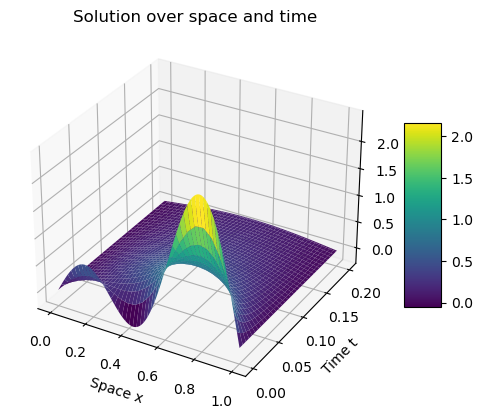

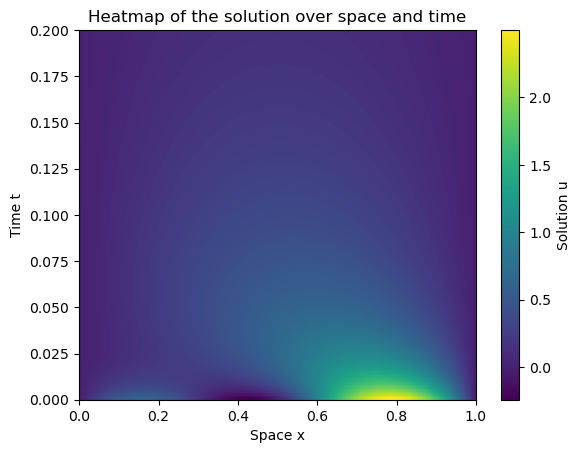

In [36]:
X, T = np.meshgrid(np.linspace(L_x, R_x, N_of_test_points_2D), np.linspace(L_t, R_t, N_of_time_steps+1))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, T, u_fem, cmap='viridis')
ax.set_xlabel('Space x')
ax.set_ylabel('Time t')
ax.set_zlabel('Solution u')
ax.set_title('Solution over space and time')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
plt.show()

fig, ax = plt.subplots()
c = ax.imshow(u_fem, extent=[L_x, R_x, L_t, R_t], origin='lower', aspect='auto', cmap='viridis')
ax.set_xlabel('Space x')
ax.set_ylabel('Time t')
ax.set_title('Heatmap of the solution over space and time')
cbar = fig.colorbar(c, ax=ax)
cbar.set_label('Solution u')
plt.show()

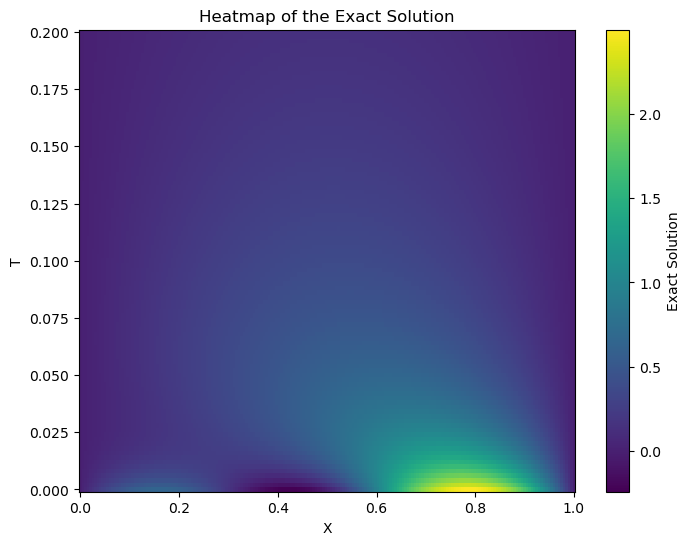

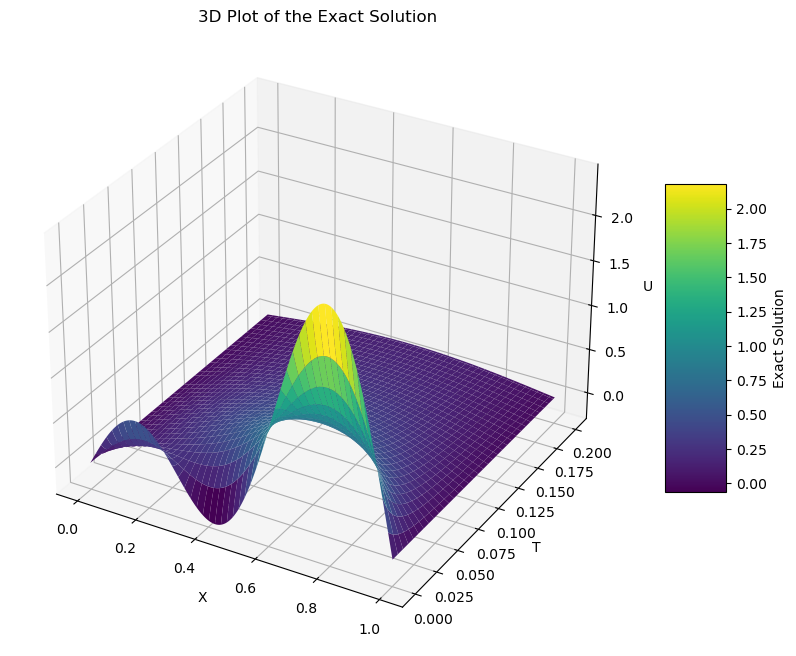

In [37]:
def exact_solution(x, t):
    term1 = np.exp(-np.power(np.pi, 2) * t) * np.sin(np.pi * x)
    term2 = -np.exp(-np.power(2 * np.pi, 2) * t) * np.sin(2 * np.pi * x)
    term3 = np.exp(-np.power(3 * np.pi, 2) * t) * np.sin(3 * np.pi * x)
    return term1 + term2 + term3


x = np.linspace(L_x, R_x, N_of_test_points_2D)
t = np.linspace(L_t, R_t, N_of_time_steps+1)
X, T = np.meshgrid(x, t)

u_exact = exact_solution(X, T)

plt.figure(figsize=(8, 6))
plt.pcolormesh(X, T, u_exact, cmap='viridis', shading='auto')
plt.colorbar(label='Exact Solution')
plt.xlabel('X')
plt.ylabel('T')
plt.title('Heatmap of the Exact Solution')
plt.show()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, T, u_exact, cmap='viridis', edgecolor='none')
fig.colorbar(surf, shrink=0.5, aspect=5, label='Exact Solution')

ax.set_xlabel('X')
ax.set_ylabel('T')
ax.set_zlabel('U')
ax.set_title('3D Plot of the Exact Solution')
plt.show()

In [38]:
def calculate_max_relative_error(u_pred, u_exact):
    u_pred_flat = u_pred.flatten()
    u_exact_flat = u_exact.flatten()
    return 100 * np.linalg.norm(u_exact_flat - u_pred_flat, np.inf) / np.linalg.norm(u_exact_flat, np.inf)

In [39]:
def relative_l2_norm_error(u_pred, u_exact):
    u_pred_flat = u_pred.flatten()
    u_exact_flat = u_exact.flatten()
    error_norm = np.linalg.norm(u_exact_flat - u_pred_flat)
    true_norm = np.linalg.norm(u_exact_flat)
    return 100 * error_norm / true_norm

In [40]:
def compute_errors(u_pinn, u_fem):
    mse_error = np.mean((u_fem - u_pinn)**2)
    print(f"Mean Squared Error (PINN and FEM): {mse_error:.3}")
    relative_error = calculate_max_relative_error(u_fem, u_pinn)
    display(Latex(f"Relative $l^{{\\infty}}$ error (PINN and FEM): {relative_error:.3}%"))
    relative_l2_error = relative_l2_norm_error(u_fem, u_pinn)
    display(Latex(f"Relative $l^{2}$ error (PINN and FEM): {relative_l2_error:.3}%"))

In [41]:
from tensorflow.keras.models import load_model
def load_epoch(epoch):
    model_path = f"model_2d_heat_ring_checkpoints/model_2d_heat_ring_at_epoch_{epoch}.h5"
    model_2D_epoch = load_model(model_path)
    u_pinn_values_epoch = model_2D_epoch(xt_test).numpy().reshape(t_test.size, x_test.size)
    return u_pinn_values_epoch

In [42]:
u_pinn_values_3000 = load_epoch(3000)

u_pinn_values_6000 = load_epoch(6000)

In [43]:
compute_errors(u_pinn, u_fem)

Mean Squared Error (PINN and FEM): 5.41e-05


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [44]:
compute_errors(u_pinn_values_3000, u_fem)

Mean Squared Error (PINN and FEM): 1.81


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [45]:
compute_errors(u_pinn_values_6000, u_fem)

Mean Squared Error (PINN and FEM): 5.4


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [47]:
print(f"Mean Squared Error (PINN and Analytical): {np.mean((u_exact - u_pinn)**2):.3}")

relative_error = calculate_max_relative_error(u_exact, u_pinn)
display(Latex(f"Relative $l^{{\\infty}}$ error (PINN and Analytical): {relative_error:.3}%"))
relative_l2_error = relative_l2_norm_error(u_exact, u_pinn)
display(Latex(f"Relative $l^{2}$ error (PINN and Analytical): {relative_l2_error:.3}%"))


Mean Squared Error (PINN and Analytical): 4.91e-05


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [63]:
print(f"Mean Squared Error (PINN and Analytical): {np.mean((u_exact - u_pinn_values_3000)**2):.3}")

relative_error = calculate_max_relative_error(u_exact, u_pinn_values_3000)
display(Latex(f"Relative $l^{{\\infty}}$ error (PINN and Analytical): {relative_error:.3}%"))
relative_l2_error = relative_l2_norm_error(u_exact, u_pinn_values_3000)
display(Latex(f"Relative $l^{2}$ error (PINN and Analytical): {relative_l2_error:.3}%"))


Mean Squared Error (PINN and Analytical): 1.81


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [64]:
print(f"Mean Squared Error (PINN and Analytical): {np.mean((u_exact - u_pinn_values_6000)**2):.3}")

relative_error = calculate_max_relative_error(u_exact, u_pinn_values_6000)
display(Latex(f"Relative $l^{{\\infty}}$ error (PINN and Analytical): {relative_error:.3}%"))
relative_l2_error = relative_l2_norm_error(u_exact, u_pinn_values_6000)
display(Latex(f"Relative $l^{2}$ error (PINN and Analytical): {relative_l2_error:.3}%"))

Mean Squared Error (PINN and Analytical): 5.4


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [48]:
print(f"Mean Squared Error (FEM and Analytical): {np.mean((u_exact - u_fem)**2):.3}")

relative_error = calculate_max_relative_error(u_exact, u_fem)
display(Latex(f"Relative $l^{{\\infty}}$ error (FEM and Analytical): {relative_error:.3}%"))
relative_l2_error = relative_l2_norm_error(u_exact, u_fem)
display(Latex(f"Relative $l^{2}$ error (FEM and Analytical): {relative_l2_error:.3}%"))


Mean Squared Error (FEM and Analytical): 1e-05


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [65]:
u_fem_10 = solve_with_fem(11, N_of_test_points_2D, N_of_time_steps)
u_fem_20 = solve_with_fem(21, N_of_test_points_2D, N_of_time_steps)
#u_fem_50 = solve_with_fem(51, N_of_test_points_2D, N_of_time_steps)
#u_fem_100 = solve_with_fem(100, N_of_test_points_2D-1, N_of_time_steps)


x_positions = np.linspace(L_x, R_x, N_of_test_points_2D)
t_positions = np.linspace(L_t, R_t, N_of_time_steps+1)

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational p

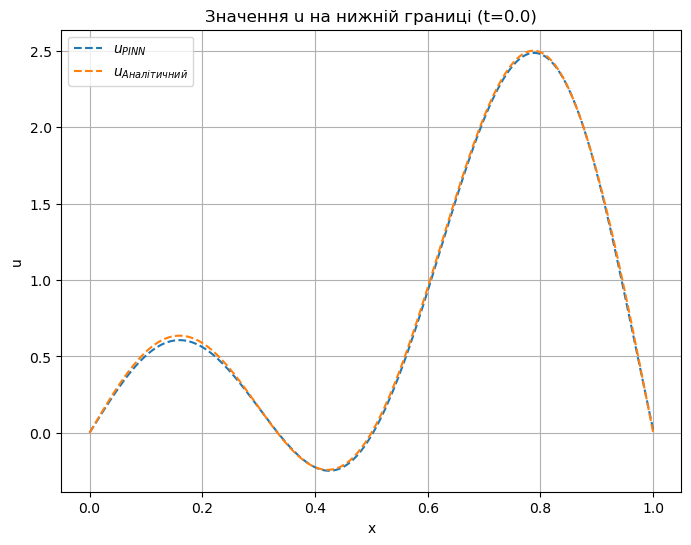

In [66]:
bottom_index = 0
#bottom_boundary_fem_values_10 = u_fem_10[bottom_index, :]
#bottom_boundary_fem_values_20 = u_fem_20[bottom_index, :]
#bottom_boundary_fem_values_50 = u_fem_50[bottom_index, :]
bottom_boundary_pinn_values = u_pinn[bottom_index, :]
bottom_boundary_analytical_values = u_exact[bottom_index, :]

plt.figure(figsize=(8, 6))
#plt.plot(x_positions, bottom_boundary_fem_values_10, label='$u_{FEM}$ 10x10')
#plt.plot(x_positions, bottom_boundary_fem_values_20, label='$u_{FEM}$ 20x20')
#plt.plot(x_positions, bottom_boundary_fem_values_50, label='$u_{FEM}$ 50x50')
plt.plot(x_positions, bottom_boundary_pinn_values, '--', label='$u_{PINN}$')
plt.plot(x_positions, bottom_boundary_analytical_values, '--', label='$u_{Аналітичний}$')
plt.xlabel('x')
plt.ylabel('u')
plt.title(f'Значення u на нижній границі (t={t_positions[bottom_index]})')
plt.legend()
plt.grid(True)
plt.show()

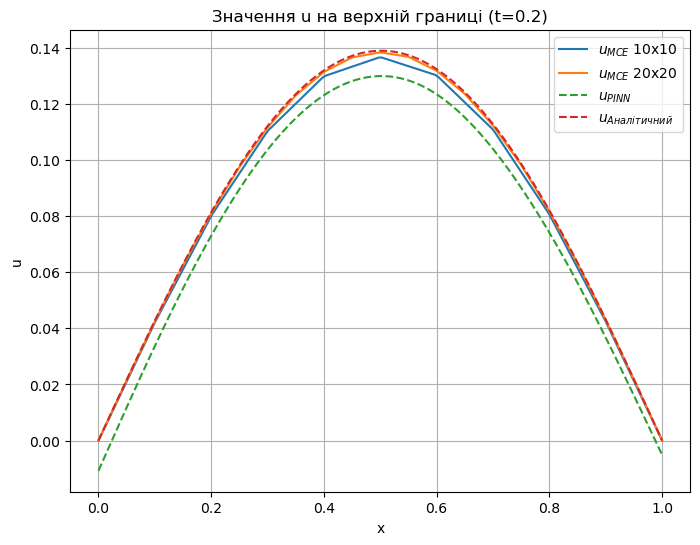

In [67]:
top_index = -1
top_boundary_fem_values_10 = u_fem_10[top_index, :]
top_boundary_fem_values_20 = u_fem_20[top_index, :]
#top_boundary_fem_values_50 = u_fem_50[top_index, :]
top_boundary_pinn_values = u_pinn[top_index, :]
top_boundary_analytical_values = u_exact[top_index, :]

plt.figure(figsize=(8, 6))
plt.plot(x_positions, top_boundary_fem_values_10, label='$u_{МСЕ}$ 10x10')
plt.plot(x_positions, top_boundary_fem_values_20, label='$u_{МСЕ}$ 20x20')
#plt.plot(x_positions, top_boundary_fem_values_50, label='$u_{FEM}$ 50x50')
plt.plot(x_positions, top_boundary_pinn_values, '--', label='$u_{PINN}$')
plt.plot(x_positions, top_boundary_analytical_values, '--', label='$u_{Аналітичний}$')
plt.xlabel('x')
plt.ylabel('u')
plt.title(f'Значення u на верхній границі (t={t_positions[top_index]})')
plt.legend()
plt.grid(True)
plt.show()

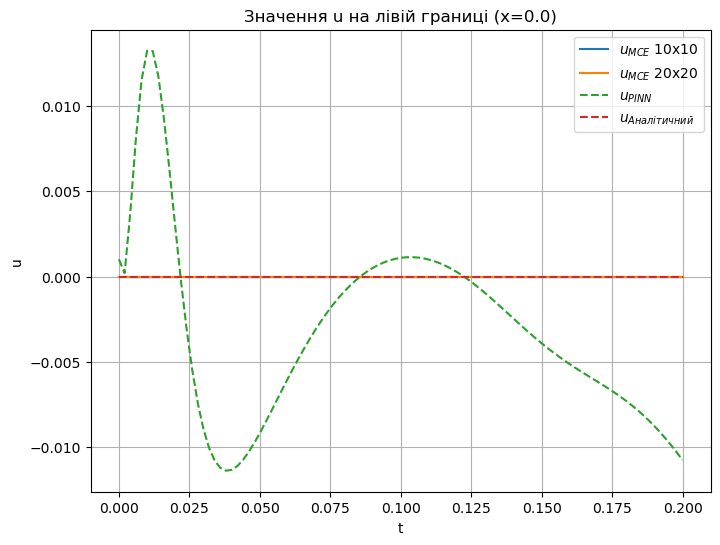

In [68]:
left_index = 0
left_boundary_fem_values_10 = u_fem_10[:, left_index]
left_boundary_fem_values_20 = u_fem_20[:, left_index]
#left_boundary_fem_values_50 = u_fem_50[:, left_index]
left_boundary_pinn_values = u_pinn[:, left_index]
left_boundary_analytical_values = u_exact[:, left_index]

plt.figure(figsize=(8, 6))
plt.plot(t_positions, left_boundary_fem_values_10, label='$u_{МСЕ}$ 10x10')
plt.plot(t_positions, left_boundary_fem_values_20, label='$u_{МСЕ}$ 20x20')
#plt.plot(t_positions, left_boundary_fem_values_50, label='$u_{FEM}$ 50x50')
plt.plot(t_positions, left_boundary_pinn_values, '--', label='$u_{PINN}$')
plt.plot(t_positions, left_boundary_analytical_values, '--', label='$u_{Аналітичний}$')
plt.xlabel('t')
plt.ylabel('u')
plt.title(f'Значення u на лівій границі (x={x_positions[left_index]})')
plt.legend()
plt.grid(True)
plt.show()

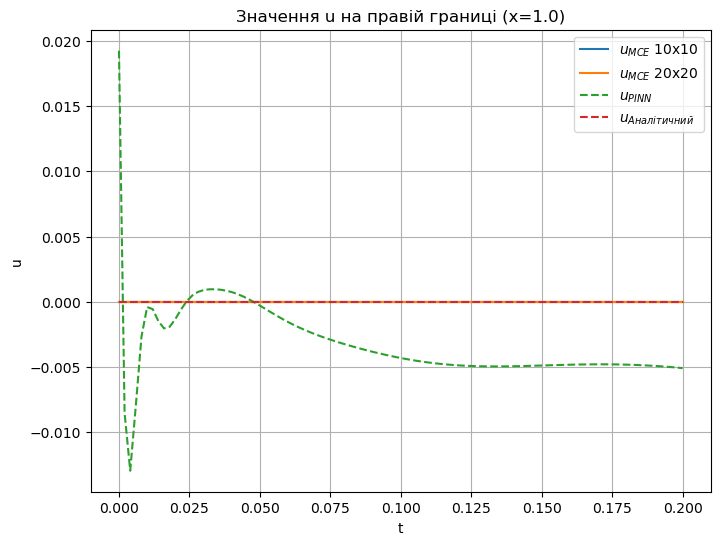

In [69]:
right_index = -1
right_boundary_fem_values_10 = u_fem_10[:, right_index]
right_boundary_fem_values_20 = u_fem_20[:, right_index]
#right_boundary_fem_values_50 = u_fem_50[:, right_index]
right_boundary_pinn_values = u_pinn[:, right_index]
right_boundary_analytical_values = u_exact[:, right_index]

plt.figure(figsize=(8, 6))
plt.plot(t_positions, right_boundary_fem_values_10, label='$u_{МСЕ}$ 10x10')
plt.plot(t_positions, right_boundary_fem_values_20, label='$u_{МСЕ}$ 20x20')
#plt.plot(t_positions, right_boundary_fem_values_50, label='$u_{FEM}$ 50x50')
plt.plot(t_positions, right_boundary_pinn_values, '--', label='$u_{PINN}$')
plt.plot(t_positions, right_boundary_analytical_values, '--', label='$u_{Аналітичний}$')
plt.xlabel('t')
plt.ylabel('u')
plt.title(f'Значення u на правій границі (x={x_positions[right_index]})')
plt.legend()
plt.grid(True)
plt.show()

In [70]:
indices_x = np.linspace(0, N_of_test_points_2D - 1, 11, dtype=int)
indices_t = np.linspace(0, N_of_time_steps - 1, 11, dtype=int)

data_top = {
    "x": np.linspace(L_x, R_x, N_of_test_points_2D)[indices_x],
    "МСЕ 10x10": top_boundary_fem_values_10[indices_x],
    "МСЕ 20x20": top_boundary_fem_values_20[indices_x],
    #"МСЕ 50x50": top_boundary_fem_values_50[indices_x],
    "PINN": top_boundary_pinn_values[indices_x],
    "Аналітичний": top_boundary_analytical_values[indices_x]
}

df_top = pd.DataFrame(data_top).round(3)
print(f"Значення u на верхній границі (t={t_positions[top_index]}):")
print(df_top)

data_bottom = {
    "x": np.linspace(L_x, R_x, N_of_test_points_2D)[indices_x],
    #"МСЕ 10x10": bottom_boundary_fem_values_10[indices_x],
    #"МСЕ 20x20": bottom_boundary_fem_values_20[indices_x],
    #"МСЕ 50x50": bottom_boundary_fem_values_50[indices_x],
    "PINN": bottom_boundary_pinn_values[indices_x],
    "Аналітичний": bottom_boundary_analytical_values[indices_x]
}

df_bottom = pd.DataFrame(data_bottom).round(3)
print(f"Значення u на нижній границі (t={t_positions[bottom_index]}):")
print(df_bottom)

Значення u на верхній границі (t=0.2):
        x  МСЕ 10x10  МСЕ 20x20   PINN  Аналітичний
0   0.000      0.000      0.000 -0.011        0.000
1   0.095      0.040      0.041  0.032        0.041
2   0.196      0.079      0.079  0.072        0.080
3   0.296      0.109      0.111  0.103        0.111
4   0.397      0.129      0.131  0.123        0.131
5   0.497      0.136      0.138  0.130        0.139
6   0.598      0.130      0.132  0.124        0.133
7   0.698      0.111      0.113  0.104        0.113
8   0.799      0.081      0.082  0.074        0.082
9   0.899      0.043      0.043  0.037        0.043
10  1.000     -0.000      0.000 -0.005        0.000
Значення u на нижній границі (t=0.0):
        x   PINN  Аналітичний
0   0.000  0.001        0.000
1   0.095  0.490        0.514
2   0.196  0.569        0.597
3   0.296  0.182        0.185
4   0.397 -0.220       -0.219
5   0.497 -0.033       -0.016
6   0.598  0.906        0.928
7   0.698  2.040        2.055
8   0.799  2.479        2.491

In [71]:
data_left = {
    "t": np.linspace(L_t, R_t, N_of_time_steps)[indices_t],
    "МСЕ 10x10": left_boundary_fem_values_10[indices_t],
    "МСЕ 20x20": left_boundary_fem_values_20[indices_t],
    #"МСЕ 50x50": left_boundary_fem_values_50[indices_t],
    "PINN": left_boundary_pinn_values[indices_t],
    "Аналітичний": left_boundary_analytical_values[indices_t]
}

df_left = pd.DataFrame(data_left).round(3)
print(f"Значення u на лівій границі (x={x_positions[left_index]}):")
print(df_left)


data_right = {
    "t": np.linspace(L_t, R_t, N_of_time_steps)[indices_t],
    "МСЕ 10x10": right_boundary_fem_values_10[indices_t],
    "МСЕ 20x20": right_boundary_fem_values_20[indices_t],
    #"МСЕ 50x50": right_boundary_fem_values_50[indices_t],
    "PINN": right_boundary_pinn_values[indices_t],
    "Аналітичний": right_boundary_analytical_values[indices_t]
}

df_right = pd.DataFrame(data_right).round(3)
print(f"Значення u на правій границі (x={x_positions[right_index]}):")
print(df_right)

Значення u на лівій границі (x=0.0):
        t  МСЕ 10x10  МСЕ 20x20   PINN  Аналітичний
0   0.000        0.0        0.0  0.001          0.0
1   0.018        0.0        0.0  0.006          0.0
2   0.038        0.0        0.0 -0.011          0.0
3   0.059        0.0        0.0 -0.007          0.0
4   0.079        0.0        0.0 -0.001          0.0
5   0.099        0.0        0.0  0.001          0.0
6   0.119        0.0        0.0  0.000          0.0
7   0.139        0.0        0.0 -0.002          0.0
8   0.160        0.0        0.0 -0.005          0.0
9   0.180        0.0        0.0 -0.007          0.0
10  0.200        0.0        0.0 -0.010          0.0
Значення u на правій границі (x=1.0):
        t  МСЕ 10x10  МСЕ 20x20   PINN  Аналітичний
0   0.000        0.0        0.0  0.019          0.0
1   0.018       -0.0        0.0 -0.002          0.0
2   0.038       -0.0        0.0  0.001          0.0
3   0.059       -0.0        0.0 -0.001          0.0
4   0.079       -0.0        0.0 -0.003   

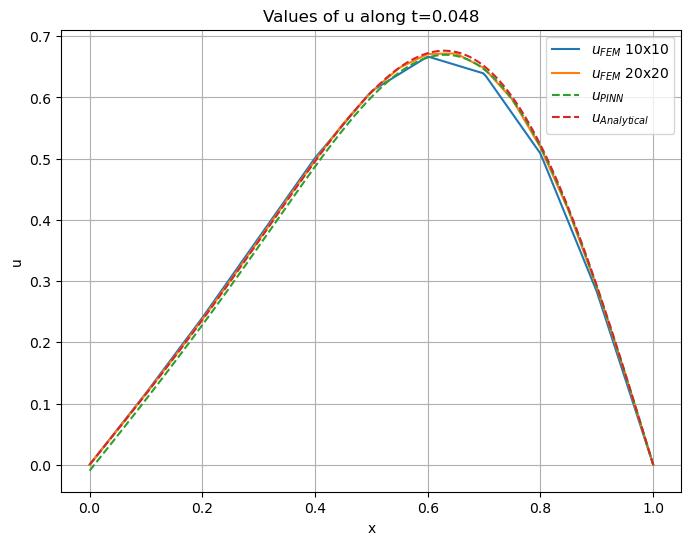

In [72]:
bottom_offset_index = int((0.05 - L_t) / ((R_t - L_t) / (N_of_time_steps - 1)))
bottom_offset_boundary_fem_values_10 = u_fem_10[bottom_offset_index, :]
bottom_offset_boundary_fem_values_20 = u_fem_20[bottom_offset_index, :]
#bottom_offset_boundary_fem_values_50 = u_fem_50[bottom_offset_index, :]
bottom_offset_boundary_pinn_values = u_pinn[bottom_offset_index, :]
bottom_offset_boundary_analytical_values = u_exact[bottom_offset_index, :]

plt.figure(figsize=(8, 6))
plt.plot(x_positions, bottom_offset_boundary_fem_values_10, label='$u_{FEM}$ 10x10')
plt.plot(x_positions, bottom_offset_boundary_fem_values_20, label='$u_{FEM}$ 20x20')
#plt.plot(x_positions, bottom_offset_boundary_fem_values_50, label='$u_{FEM}$ 50x50')
plt.plot(x_positions, bottom_offset_boundary_pinn_values, '--', label='$u_{PINN}$')
plt.plot(x_positions, bottom_offset_boundary_analytical_values, '--', label='$u_{Analytical}$')
plt.xlabel('x')
plt.ylabel('u')
plt.title(f'Values of u along t={t_positions[bottom_offset_index]}')
plt.legend()
plt.grid(True)
plt.show()

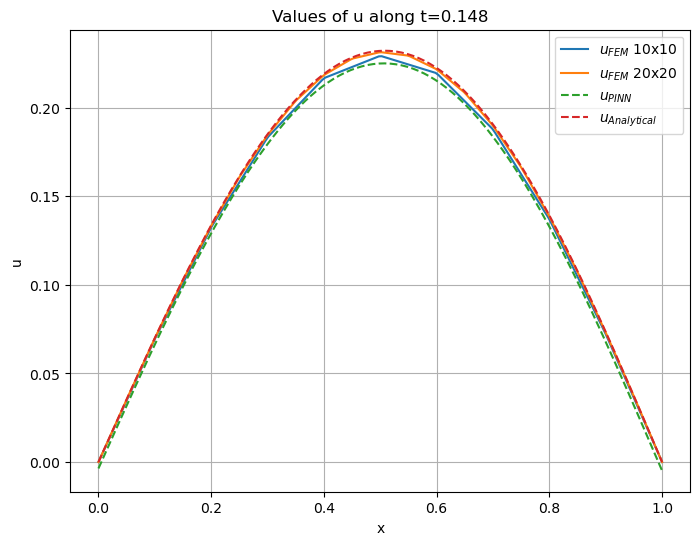

In [73]:
top_offset_index = int((0.15 - L_t) / ((R_t - L_t) / (N_of_time_steps - 1)))
top_offset_boundary_fem_values_10 = u_fem_10[top_offset_index, :]
top_offset_boundary_fem_values_20 = u_fem_20[top_offset_index, :]
#top_offset_boundary_fem_values_50 = u_fem_50[top_offset_index, :]
top_offset_boundary_pinn_values = u_pinn[top_offset_index, :]
top_offset_boundary_analytical_values = u_exact[top_offset_index, :]

plt.figure(figsize=(8, 6))
plt.plot(x_positions, top_offset_boundary_fem_values_10, label='$u_{FEM}$ 10x10')
plt.plot(x_positions, top_offset_boundary_fem_values_20, label='$u_{FEM}$ 20x20')
#plt.plot(x_positions, top_offset_boundary_fem_values_50, label='$u_{FEM}$ 50x50')
plt.plot(x_positions, top_offset_boundary_pinn_values, '--', label='$u_{PINN}$')
plt.plot(x_positions, top_offset_boundary_analytical_values, '--', label='$u_{Analytical}$')
plt.xlabel('x')
plt.ylabel('u')
plt.title(f'Values of u along t={t_positions[top_offset_index]}')
plt.legend()
plt.grid(True)
plt.show()

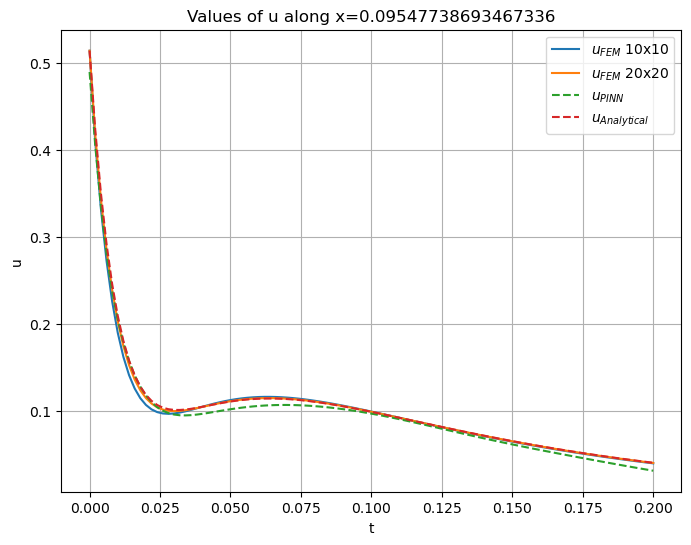

In [74]:
left_offset_index = int((0.1 - L_x) / ((R_x - L_x) / (N_of_test_points_2D - 1)))
left_offset_boundary_fem_values_10 = u_fem_10[:, left_offset_index]
left_offset_boundary_fem_values_20 = u_fem_20[:, left_offset_index]
#left_offset_boundary_fem_values_50 = u_fem_50[:, left_offset_index]
left_offset_boundary_pinn_values = u_pinn[:, left_offset_index]
left_offset_boundary_analytical_values = u_exact[:, left_offset_index]

plt.figure(figsize=(8, 6))
plt.plot(t_positions, left_offset_boundary_fem_values_10, label='$u_{FEM}$ 10x10')
plt.plot(t_positions, left_offset_boundary_fem_values_20, label='$u_{FEM}$ 20x20')
#plt.plot(t_positions, left_offset_boundary_fem_values_50, label='$u_{FEM}$ 50x50')
plt.plot(t_positions, left_offset_boundary_pinn_values, '--', label='$u_{PINN}$')
plt.plot(t_positions, left_offset_boundary_analytical_values, '--', label='$u_{Analytical}$')
plt.xlabel('t')
plt.ylabel('u')
plt.title(f'Values of u along x={x_positions[left_offset_index]}')
plt.legend()
plt.grid(True)
plt.show()

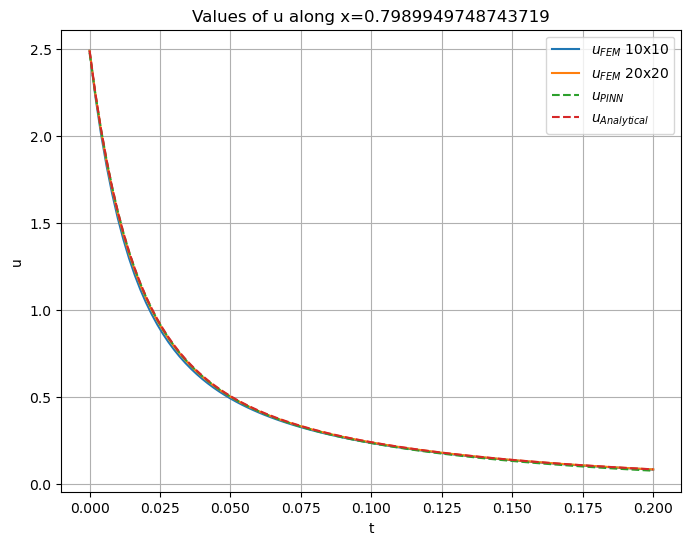

In [75]:
right_offset_index = int((0.8 - L_x) / ((R_x - L_x) / (N_of_test_points_2D - 1)))
right_offset_boundary_fem_values_10 = u_fem_10[:, right_offset_index]
right_offset_boundary_fem_values_20 = u_fem_20[:, right_offset_index]
#right_offset_boundary_fem_values_50 = u_fem_50[:, right_offset_index]
right_offset_boundary_pinn_values = u_pinn[:, right_offset_index]
right_offset_boundary_analytical_values = u_exact[:, right_offset_index]

plt.figure(figsize=(8, 6))
plt.plot(t_positions, right_offset_boundary_fem_values_10, label='$u_{FEM}$ 10x10')
plt.plot(t_positions, right_offset_boundary_fem_values_20, label='$u_{FEM}$ 20x20')
#plt.plot(t_positions, right_offset_boundary_fem_values_50, label='$u_{FEM}$ 50x50')
plt.plot(t_positions, right_offset_boundary_pinn_values, '--', label='$u_{PINN}$')
plt.plot(t_positions, right_offset_boundary_analytical_values, '--', label='$u_{Analytical}$')
plt.xlabel('t')
plt.ylabel('u')
plt.title(f'Values of u along x={x_positions[right_offset_index]}')
plt.legend()
plt.grid(True)
plt.show()

In [76]:
indices_x = np.linspace(0, N_of_test_points_2D - 1, 11, dtype=int)
indices_t = np.linspace(0, N_of_time_steps - 1, 11, dtype=int)

data_top_offset = {
    "x": np.linspace(L_x, R_x, N_of_test_points_2D)[indices_x],
    "FEM 10x10": top_offset_boundary_fem_values_10[indices_x],
    "FEM 20x20": top_offset_boundary_fem_values_20[indices_x],
    #"FEM 50x50": top_offset_boundary_fem_values_50[indices_x],
    "PINN": top_offset_boundary_pinn_values[indices_x],
    "Analytical": top_offset_boundary_analytical_values[indices_x]
}

df_top_offset = pd.DataFrame(data_top_offset).round(3)
print(f"Values at t={t_positions[top_offset_index]}:")
print(df_top_offset)

data_bottom_offset = {
    "x": np.linspace(L_x, R_x, N_of_test_points_2D)[indices_x],
    "FEM 10x10": bottom_offset_boundary_fem_values_10[indices_x],
    "FEM 20x20": bottom_offset_boundary_fem_values_20[indices_x],
    #"FEM 50x50": bottom_offset_boundary_fem_values_50[indices_x],
    "PINN": bottom_offset_boundary_pinn_values[indices_x],
    "Analytical": bottom_offset_boundary_analytical_values[indices_x]
}

df_bottom_offset = pd.DataFrame(data_bottom_offset).round(3)
print(f"Values at t={t_positions[bottom_offset_index]}:")
print(df_bottom_offset)



Values at t=0.148:
        x  FEM 10x10  FEM 20x20   PINN  Analytical
0   0.000      0.000      0.000 -0.004       0.000
1   0.095      0.066      0.067  0.063       0.067
2   0.196      0.130      0.131  0.127       0.131
3   0.296      0.181      0.183  0.178       0.183
4   0.397      0.216      0.218  0.212       0.218
5   0.497      0.229      0.231  0.225       0.232
6   0.598      0.220      0.222  0.216       0.223
7   0.698      0.188      0.190  0.184       0.191
8   0.799      0.138      0.139  0.133       0.140
9   0.899      0.073      0.073  0.068       0.074
10  1.000     -0.000      0.000 -0.005       0.000
Values at t=0.048:
        x  FEM 10x10  FEM 20x20   PINN  Analytical
0   0.000      0.000      0.000 -0.010       0.000
1   0.095      0.112      0.110  0.101       0.110
2   0.196      0.235      0.232  0.223       0.231
3   0.296      0.366      0.362  0.352       0.361
4   0.397      0.497      0.493  0.483       0.492
5   0.497      0.607      0.607  0.598      

In [77]:
data_left_offset = {
    "t": np.linspace(L_t, R_t, N_of_time_steps)[indices_t],
    "FEM 10x10": left_offset_boundary_fem_values_10[indices_t],
    "FEM 20x20": left_offset_boundary_fem_values_20[indices_t],
    #"FEM 50x50": left_offset_boundary_fem_values_50[indices_t],
    "PINN": left_offset_boundary_pinn_values[indices_t],
    "Analytical": left_offset_boundary_analytical_values[indices_t]
}

df_left_offset = pd.DataFrame(data_left_offset).round(3)
print(f"Values at x={x_positions[left_offset_index]}:")
print(df_left_offset)


data_right_offset = {
    "t": np.linspace(L_t, R_t, N_of_time_steps)[indices_t],
    "FEM 10x10": right_offset_boundary_fem_values_10[indices_t],
    "FEM 20x20": right_offset_boundary_fem_values_20[indices_t],
    #"FEM 50x50": right_offset_boundary_fem_values_50[indices_t],
    "PINN": right_offset_boundary_pinn_values[indices_t],
    "Analytical": right_offset_boundary_analytical_values[indices_t]
}

df_right_offset = pd.DataFrame(data_right_offset).round(3)
print(f"Values at x={x_positions[right_offset_index]}:")
print(df_right_offset)

Values at x=0.09547738693467336:
        t  FEM 10x10  FEM 20x20   PINN  Analytical
0   0.000      0.514      0.514  0.490       0.514
1   0.018      0.115      0.124  0.128       0.128
2   0.038      0.103      0.104  0.096       0.104
3   0.059      0.116      0.115  0.106       0.114
4   0.079      0.113      0.112  0.106       0.112
5   0.099      0.101      0.101  0.098       0.101
6   0.119      0.087      0.087  0.085       0.087
7   0.139      0.073      0.073  0.070       0.073
8   0.160      0.060      0.061  0.057       0.061
9   0.180      0.050      0.050  0.044       0.050
10  0.200      0.041      0.041  0.033       0.042
Values at x=0.7989949748743719:
        t  FEM 10x10  FEM 20x20   PINN  Analytical
0   0.000      2.491      2.491  2.479       2.491
1   0.018      1.118      1.144  1.152       1.154
2   0.038      0.631      0.645  0.647       0.651
3   0.059      0.424      0.432  0.431       0.435
4   0.079      0.311      0.316  0.314       0.318
5   0.099      0.

In [78]:
from docx import Document

doc = Document()
def addTable(df, text):
    doc.add_paragraph(text)
    table = doc.add_table(rows=1, cols=len(df.columns))

    table.style = 'Table Grid'

    hdr_cells = table.rows[0].cells
    for i, col_name in enumerate(df.columns):
        hdr_cells[i].text = col_name

    for index, row in df.iterrows():
        row_cells = table.add_row().cells
        for i, value in enumerate(row):
            row_cells[i].text = str(value)

    

addTable(df_left, "Left")
addTable(df_right, "Right")
addTable(df_top, "Top")
addTable(df_bottom, "Bottom")

doc.save('/mnt/c/output_table_heat.docx')
